In [ ]:
!pip install rawpy imageio exifread

import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

In [48]:
import rawpy
import matplotlib.pyplot as plt
import io # Import io
################################################################################
def load_image(file_name= 'MIT_FiveK_5.dng'):
    """
    """

    with rawpy.imread(file_name) as raw:

        raw_data = raw.raw_image_visible
        white_level = raw.white_level  # e.g., 1023, 4095, etc.
        bit_depth = int(np.ceil(np.log2(white_level + 1)))
        print("Bit Depth= ", bit_depth)

        bayer_img = raw.raw_image_visible.astype(np.uint32)  # raw, not postprocessed!

        bl = raw.black_level_per_channel
        print("Black Level per channel:", bl)

        pattern = raw.raw_pattern
        color_map = {0: 'R', 1: 'G', 2: 'B', 3: 'G'}
        named_pattern = np.vectorize(color_map.get)(pattern)
        print(named_pattern)

        rgb_image= raw.postprocess()

        # Convert embedded thumbnail to NumPy array
        thumbnail = raw.extract_thumb()
        print(thumbnail.format) # we this later
        if thumbnail.format == rawpy.ThumbFormat.JPEG:
            img = Image.open(io.BytesIO(thumbnail.data))
            thumbnail_np = np.array(img.convert("L"))  # convert to grayscale
        elif thumbnail.format == rawpy.ThumbFormat.BITMAP:
            thumbnail_np = np.array(thumbnail.data)
        else:
            raise ValueError("Unknown thumbnail format")

    return bayer_img.astype(np.uint16), bl, thumbnail_np, bit_depth

################################################################################
def BLC_RGGB(image,bl):
    bl_r, bl_gr, bl_gb, bl_b = bl

    H, W = image.shape
    print(H, W)

    corrected = image.astype(np.int32)
    corrected[0::2, 0::2] -= bl_r   # R
    corrected[0::2, 1::2] -= bl_gr  # Gr
    corrected[1::2, 0::2] -= bl_gb  # Gb
    corrected[1::2, 1::2] -= bl_b   # B

    BLC_image = np.clip(corrected, 0, None).astype(np.uint16)
    return BLC_image

Bit Depth=  12
Black Level per channel: [127, 128, 127, 127]
[['R' 'G']
 ['G' 'B']]
ThumbFormat.BITMAP
2348 3522


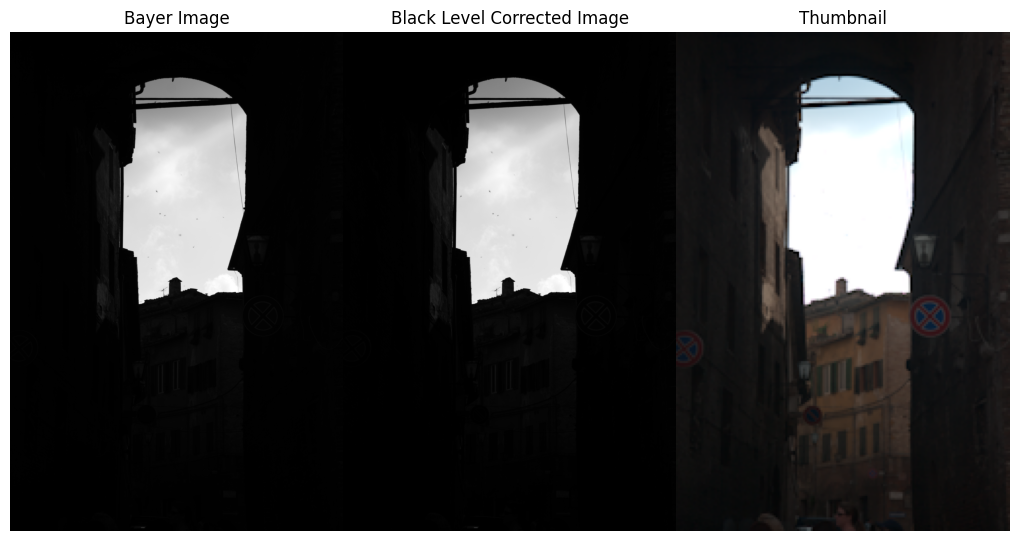

In [49]:
import cv2

bayer_img, bl, thumbnail_np, bit_depth = load_image(file_name= 'MIT_FiveK_5.dng')

BLC_image = BLC_RGGB(bayer_img,bl)

BLC_image_rotated = cv2.rotate(BLC_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
bayer_img_rotated= cv2.rotate(bayer_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
thumbnail_np_rotated = cv2.rotate(thumbnail_np, cv2.ROTATE_90_COUNTERCLOCKWISE)

fig, axes = plt.subplots(1,3,figsize=(10, 5))
axes[0].imshow(bayer_img_rotated, cmap='gray')
axes[0].set_title('Bayer Image')
axes[0].axis('off')
axes[1].imshow(BLC_image_rotated, cmap='gray')
axes[1].set_title('Black Level Corrected Image')
axes[1].axis('off')

axes[2].imshow(thumbnail_np_rotated, cmap='gray')
axes[2].set_title('Thumbnail')
axes[2].axis('off')

plt.tight_layout(pad=0)
plt.show()
